In [4]:
%load_ext autoreload
%autoreload 2

#standard imports
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

#rl book imports
import rl
from rl.markov_decision_process import MarkovDecisionProcess
from rl.markov_process import State, MarkovProcess, NonTerminal, Terminal

from typing import (Callable, Dict, Generic, Iterator, Iterable, List,
                    Mapping, Optional, Sequence, Tuple, TypeVar, overload)


from rl.distribution import Categorical, Distribution, Constant, Choose
from rl.policy import Policy
from rl.monte_carlo import epsilon_greedy_policy, greedy_policy_from_qvf, glie_mc_control, mc_prediction
from rl.function_approx import LinearFunctionApprox, AdamGradient
from rl.td import glie_sarsa, q_learning
from rl.td_lambda import td_lambda_prediction


#custom imports 
import utils as u
import data as dat
import mdp_agent as ag
import baseline_policies as bp
import q_plots as qp
import backtest as btest
import v_predictor as v_true

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%pip install graphviz 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
GAMMA = 0.8

#  Predict V for OU

In [6]:
constant_params = {
    "mu":   lambda t : 100,
    "sigma": lambda t : 0.2,
    "kappa":  lambda t : 1/10
}

time_varying_params = {
    "mu":   lambda t : 100 + t*0.005,
    "kappa":   lambda t : 1/(15+5*np.cos(np.pi*t/30)),
    "sigma":    lambda t: 0.2    
}

params = constant_params

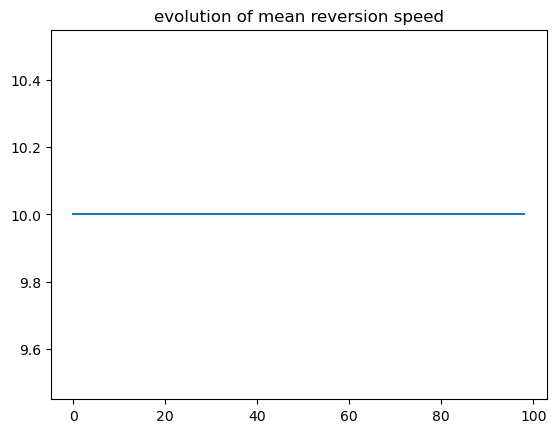

In [7]:
plt.title("evolution of mean reversion speed")
plt.plot([1/params["kappa"](t) for t in np.arange(1,100,1)])

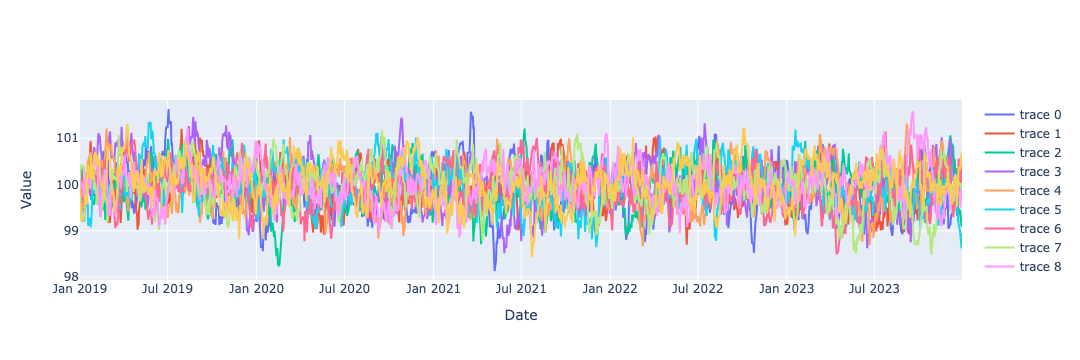

In [8]:
train, test = dat.build_simulated_train_test(N=10,mu=params["mu"],sigma=params["sigma"],kappa=params["kappa"])
u.plot_plotly_multiple(train)

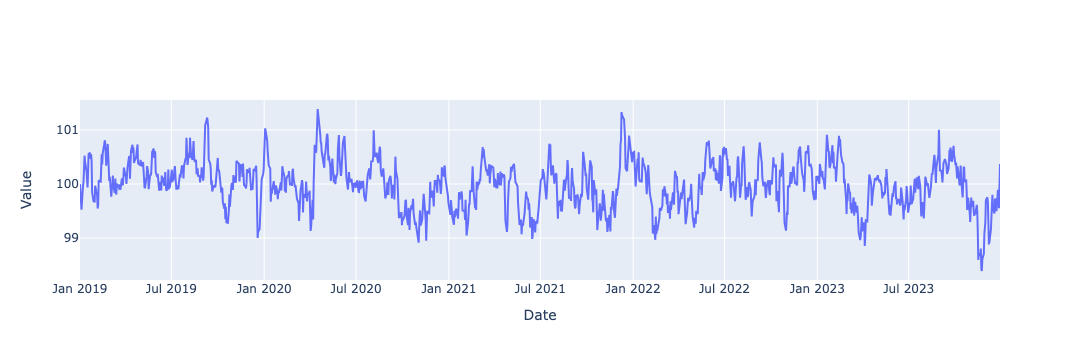

In [9]:
u.plot_plotly(test)

In [10]:
len(test)

1304

# Get true value function for these params

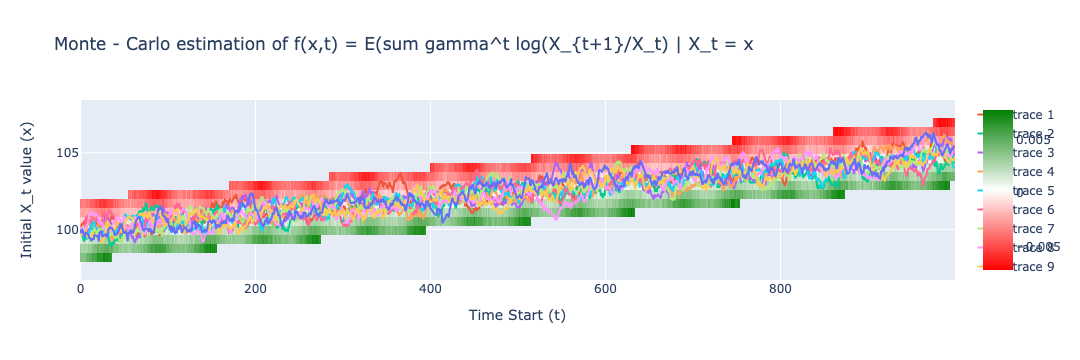

In [64]:
#prediction = v_true.Prediction(mu, kappa, sigma)

prediction = v_true.Prediction(mu  = params["mu"] , kappa = params["kappa"], sigma = params["sigma"] )

t_range = np.arange(0, 1000, 1)  # Example time range

gamma = GAMMA

num_paths = 100

# Generate the heatmap values and plot
x_range, t_range, f_heatmap_values = prediction.generate_f_heatmap(t_range, gamma, num_paths)
prediction.plot_heatmap(x_range, t_range, f_heatmap_values)

# Feature design

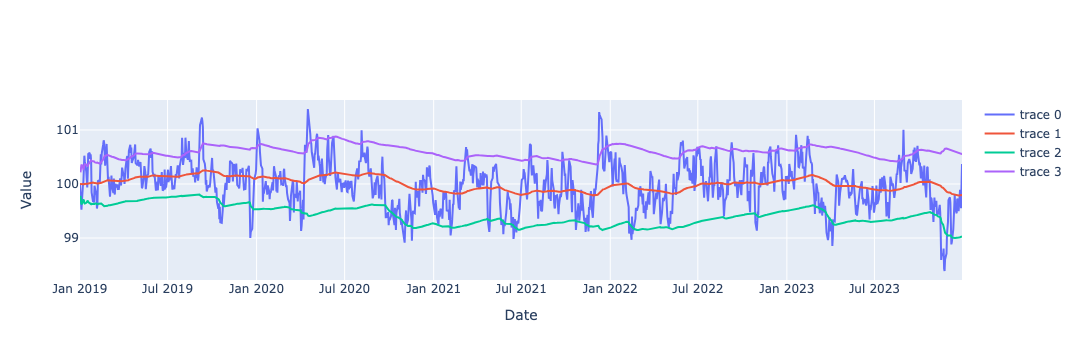

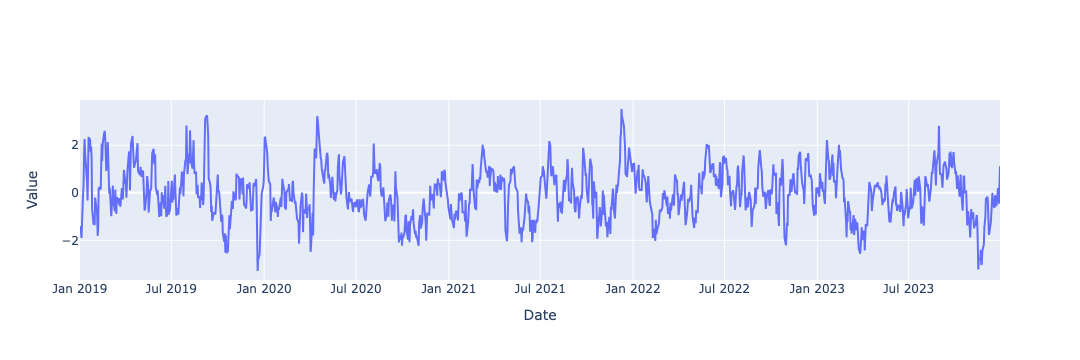

In [11]:
df = u.ts_features(test)

u.plot_plotly_multiple([df[[df.columns[0]]],df[["mu_t"]],df[["S_down"]],df[["S_up"]]])

u.plot_plotly(df[["z_score"]])

# Get trader

In [12]:
trader = ag.Trading(train,test,lookback=30)
mrp_buy = trader.apply_policy(bp.BuyAndHold())

In [13]:
example_state = trader.generate_start_state("test").sample()

In [14]:
example_state.state["sigma_t"]

0.2472321406209957

# Create features functions

In [88]:
def intercept(x):
    return 1

def z_score_state(x):
    return (x.state["Spot"] - x.state["mu_t"])/(x.state["sigma_t"])
    

v_approx = LinearFunctionApprox.create(feature_functions=[intercept,z_score_state])

In [102]:
v_approx

LinearFunctionApprox(feature_functions=[<function intercept at 0x7fcb70308b80>, <function z_score_state at 0x7fcb70308790>], regularization_coeff=0.0, weights=Weights(adam_gradient=AdamGradient(learning_rate=0.001, decay1=0.9, decay2=0.999), time=0, weights=array([0., 0.]), adam_cache1=array([0., 0.]), adam_cache2=array([0., 0.])), direct_solve=True)

# MC Prediction

In [92]:
initial_state = trader.generate_start_state("train")
traces = mrp_buy.reward_traces(initial_state)


vfs_mc = mc_prediction(
    traces,
    v_approx,
    GAMMA,
    1e-6
)

num_iter = 1000

final_v_mc = None

for i,vf in enumerate(vfs_mc):
    if i>=num_iter:
        break 
    if i%100==0:
        print(i)

    final_v_mc = vf

0
100
200
300
400
500
600
700
800
900


In [104]:
example_state

NonTerminal(state={'Spot': 100.37141042330317, 'position': 0, 'date': Timestamp('2019-02-12 00:00:00', freq='B'), 'data':                  Value
2019-01-01  100.000000
2019-01-02   99.795905
2019-01-03   99.691211
2019-01-04   99.523577
2019-01-07   99.971861
...                ...
2023-12-25   99.891229
2023-12-26   99.818381
2023-12-27   99.550822
2023-12-28  100.039099
2023-12-29  100.367606

[1304 rows x 1 columns], 'lookback': 30, 'time index': 0, 'ts_features':                  Value        mu_t   sigma_t     S_down        S_up   z_score
2019-01-01  100.000000  100.000000       NaN        NaN         NaN       NaN
2019-01-02   99.795905   99.997969  0.144317  99.781494  100.214444 -1.400142
2019-01-03   99.691211   99.994917  0.184861  99.717625  100.272208 -1.642889
2019-01-04   99.523577   99.990227  0.246070  99.621123  100.359331 -1.896412
2019-01-07   99.971861   99.990044  0.213192  99.670256  100.309832 -0.085290
...                ...         ...       ...        ...     

In [105]:
final_v_mc(example_state)

-0.013002946942017089

In [93]:
with open("v_predictors/v1.pkl","wb") as f:
    pickle.dump(final_v_mc,f)

## TD lambda

In [80]:
vfs_td_lambda = td_lambda_prediction(
        traces,
        approx_0,
        0.9,
        0.8
)

num_iter = 10000

final_v_td_l = None

for i,vf in enumerate(vfs_td_lambda):
    if i>=num_iter:
        break 

    final_v_td_l = vf

# Retained v

In [19]:
v_feat = final_v_mc

In [77]:
trader.set_v_approx(v_feat)

## dirty code to quickly plot V

In [79]:
import pickle

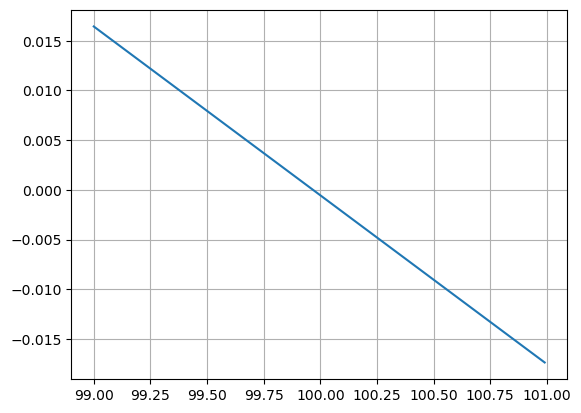

In [106]:
spot_range = np.arange(100-1,100+1,0.01)

state_dicts = [NonTerminal({
            "Spot" : s,
            "position" : 1,
            "date" : "2020-01-01",
            "data" : train[3],
            "lookback": 100,
            "time index": 0,
            "mu_t":100,
            "sigma_t":0.2
        }) for s in spot_range]

plt.plot(spot_range,[v_feat(s) for s in state_dicts])
plt.grid()

# Now that we have V, include it as feature

In [97]:
trader = ag.Trading(train,test,lookback=100)

ffs = [

    lambda x: 1 if ((x[0].state["position"]==0)and (x[1] == -1 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==0)and (x[1] == 0 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==0)and (x[1] == 1 )) else 0,

    lambda x: 1 if ((x[0].state["position"]==1)and (x[1] == -1 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==1)and (x[1] == 0 )) else 0,

    lambda x: 1 if ((x[0].state["position"]==-1)and (x[1] == 0 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==-1)and (x[1] == 1 )) else 0,

    lambda x:  v_feat(x[0]) if ((x[0].state["position"]==0)and (x[1] == -1 )) else 0,
    lambda x:  v_feat(x[0]) if ((x[0].state["position"]==0)and (x[1] == 0 )) else 0,
    lambda x:  v_feat(x[0]) if ((x[0].state["position"]==0)and (x[1] == 1 )) else 0,

    lambda x:  v_feat(x[0]) if ((x[0].state["position"]==1)and (x[1] == -1 )) else 0,
    lambda x:  v_feat(x[0]) if ((x[0].state["position"]==1)and (x[1] == 0 )) else 0,

    lambda x:  v_feat(x[0]) if ((x[0].state["position"]==-1)and (x[1] == 0 )) else 0,
    lambda x:  v_feat(x[0]) if ((x[0].state["position"]==-1)and (x[1] == 1 )) else 0,
  
]

q_approx = LinearFunctionApprox.create(feature_functions=ffs)

In [100]:
qvfs_mc = glie_mc_control(
    trader,
    trader.generate_start_state("train"),
    q_approx,
    GAMMA,
    lambda k: 1/k
)

In [101]:
num_iter = 100000
final_qvf = None
for i,qvf in enumerate(qvfs_mc):
    if i%500==0:
        print(i)
    if i>=num_iter:
        break
    final_qvf = qvf

0
500
1000
1500


KeyboardInterrupt: 

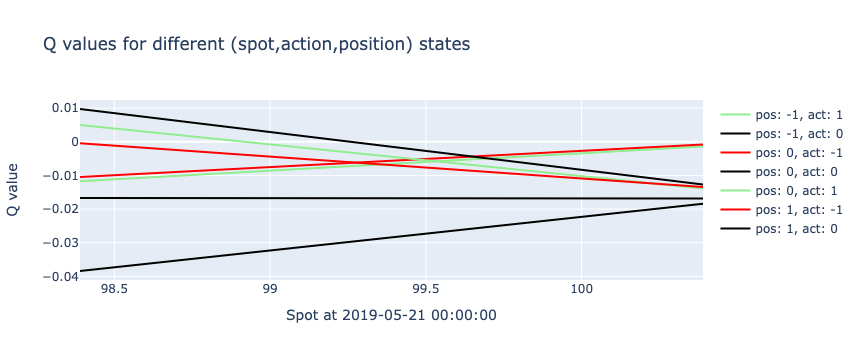

In [62]:
qanalysis = qp.QAnalyzer(test,final_qvf)
qanalysis.plot_snapshot(trader.generate_start_state("train").sample())

In [38]:
q_approx = LinearFunctionApprox.create(feature_functions=ffs)


qvfs_sarsa = glie_sarsa(
    trader,
    trader.generate_start_state("train"),
    q_approx,
    GAMMA,
    lambda k: 1/k,
    1000
)

num_iter = 1000
final_qvf_sarsa= None
for i,qvf in enumerate(qvfs_sarsa):
    if i%1000==0:
        print(i)
    if i>=num_iter:
        break
    final_qvf_sarsa = qvf

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


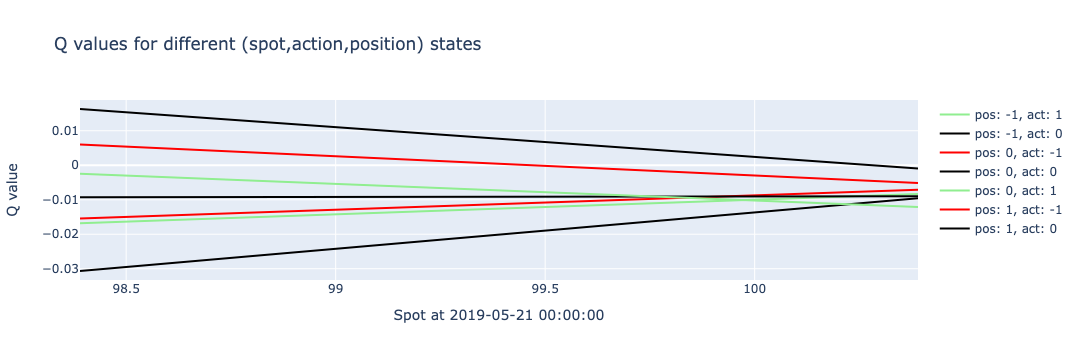

In [39]:
qanalysis = qp.QAnalyzer(test,final_qvf)
qanalysis.plot_snapshot(trader.generate_start_state("train").sample())

## q learning

In [57]:
def pol_from_q(q,mdp):
    return epsilon_greedy_policy(q,mdp,ε=0.5)


q_approx = LinearFunctionApprox.create(feature_functions=ffs)

qvfs_q_learn = q_learning(
    trader,
    pol_from_q,
    trader.generate_start_state("train"),
    q_approx,
    GAMMA,
    1000
)

In [58]:
num_iter = 100000
final_qvf_q_learn= None
for i,qvf in enumerate(qvfs_q_learn):
    if i%1000==0:
        print(i)
    if i>=num_iter:
        break
    final_qvf_q_learn = qvf

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


KeyboardInterrupt: 

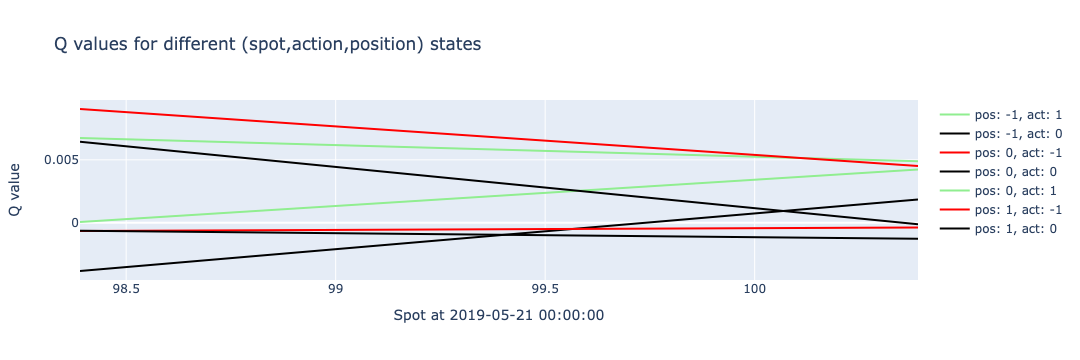

In [51]:
qanalysis = qp.QAnalyzer(test,final_qvf_q_learn)
qanalysis.plot_snapshot(trader.generate_start_state("train").sample())

# LSPI

In [53]:
from rl.td import q_learning_experience_replay

# Q learning exp replay 

In [55]:
q_approx = LinearFunctionApprox.create(feature_functions=ffs)

qvfs_zebi = q_learning_experience_replay(
    trader,
    pol_from_q,
    trader.generate_start_state("train"),
    q_approx,
    GAMMA,
    1000,
    10,
    20
)

In [56]:
num_iter = 10000
final_q_z = None
for i,qvf in enumerate(qvfs_zebi):
    if i%1000==0:
        print(i)
    if i>=num_iter:
        break
    final_q_z = qvf

0


TypeError: unhashable type: 'dict'

# Backtest

/Users/mehdi/Desktop/cme241/RL_Project/utils.py:97: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.



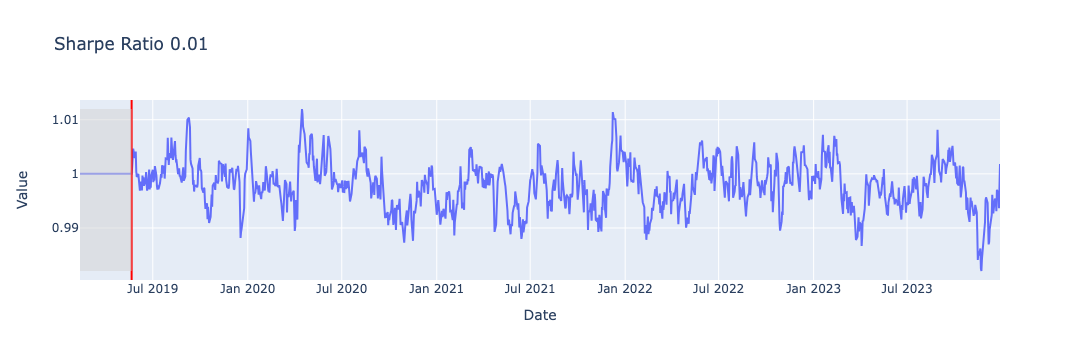

In [52]:
trading_policy  = greedy_policy_from_qvf(final_qvf_sarsa, lambda x : [-1,0,1])
bt = btest.Backtester(trader,trading_policy)
bt.summary()